In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
training = fc.eightb.training.training_5M
module = fc.eightb.preselection.t8btag_minmass

In [7]:
def get_files(f): 
    return f
    # return f.replace("ntuple.root","fully_res_ntuple_*.root")
signal = ObjIter( Tree(get_files(f),  altfile='t8btag_minmass_{base}', report=False) for f in tqdm(module.signal_list))

100%|██████████| 3/3 [00:07<00:00,  2.41s/it]


In [8]:
def get_ttbar(ttbar):
    return ttbar[0].replace("ntuple_0","ntuple_{6,7}")

In [9]:
bkg = ObjIter( [Tree(module.Run2_UL18.QCD_B_List,  altfile='t8btag_minmass_{base}',), Tree(module.Run2_UL18.TTJets,  altfile='t8btag_minmass_{base}',)] )


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


In [10]:
quadh_index = to_pair_combinations(*combinations(8, [2,2,2,2]).transpose(2,1,0))


In [11]:
signal.apply(lambda t : t.extend(quadh_m=t.higgs_m))

[None, None, None]

In [12]:
class soverb(ObjTransform):
    def __call__(self, histos=None, stack=None, ax=None, **kwargs):
        if stack is not None:
            x = stack.array
            w = stack.weights

            sr_mask = np.abs(x - self.r) < self.cut
            self.bkg_sr = ak.sum(w[sr_mask])
            return

        def _sr_(h):
            x = h.array
            w = h.weights

            sr_mask = np.abs(x - 125) < 30
            return ak.sum(w[sr_mask])
        signal_sr = histos.apply(_sr_).npy
        soverb = signal_sr/np.sqrt(self.bkg_sr)
        soverb = np.mean(soverb)

        ax.text(0.7,0.7, f'$S/\sqrt{{B}} = {soverb:0.2f}$', transform=ax.transAxes)

        ylim = ax.get_ylim()
        ax.plot([self.r-self.cut]*2, ylim, color='grey', linestyle='--')
        ax.plot([self.r+self.cut]*2, ylim, color='grey', linestyle='--')

In [123]:
def rank_higgs_m(higgs_m):
    # outside higgs mass

    x = np.abs(higgs_m-125)/100
    x = np.sqrt(np.sum(x**2,axis=1))
    return 1.0*(x > 1)

    # return np.abs(higgs_m - 125) > 50
    # return np.abs(higgs_m - 125) > 25
    # return 1-np.exp( - ( (higgs_m - 125)/25 )**2 )
    # return 1-np.exp( - ( (higgs_m - 125)/50 )**2 )
    # return 1-np.exp( - ( (higgs_m - 125)/125 )**2 )

    #centered around
    # return np.exp( - ( (higgs_m - 250)/25 )**2 )

    # exponential decay
    # return np.exp( -(higgs_m/10) )
    # return np.exp( -(higgs_m/60) )
    # return np.exp( -(higgs_m/125) )
    # return np.exp( -(higgs_m/250) )
    # return np.exp( -(higgs_m/500) )

In [ ]:
x = np.linspace(0,300,100)
r = rank_higgs_m(x)

graph_array(x, r, xlabel='DiJet Mass', ylabel='Rank')

In [102]:
def rank_higgs_m(higgs_m):
    # asym
    # h1, h2 = ak.unzip(ak.combinations(higgs_m, n=2, axis=1))
    # asym = (h1-h2)/(h1+h2)
    # asym = np.sqrt(ak.sum(asym**2, axis=1))
    # return asym

    # higgs_dm2 = (higgs_m-125)**2
    # return np.sqrt(ak.sum(higgs_dm2,axis=1)) > 30
    higgs_dm2 = ( (higgs_m-125)/50 )**2
    return 1 - np.exp( -ak.sum(higgs_dm2,axis=1) )
    # return np.exp( -ak.sum(higgs_dm2,axis=1) )


ValueError: zero-size array to reduction operation maximum which has no identity

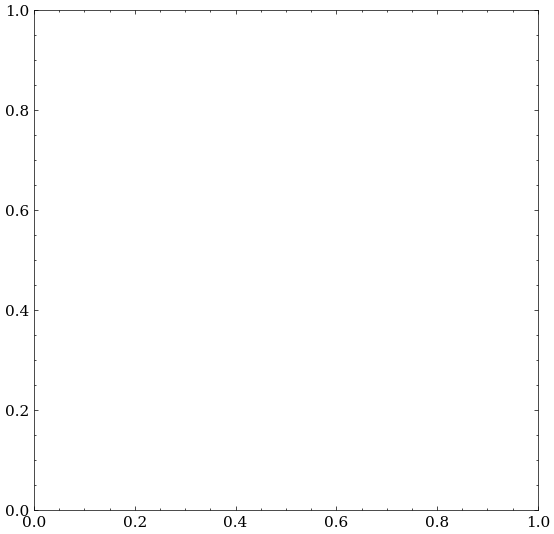

In [116]:
x = 125 + 100*(ak.from_numpy(np.random.random(size=(1000,4,105)))-0.5)
y = rank_higgs_m(x)
hist2d_multi([ak.mean(x,axis=1)],[y],scatter=True, y_bins=np.linspace(0,2,3))

In [117]:
np.exp( - ( (higgs_m - 125)/50 )**2 )

NameError: name 'higgs_m' is not defined

In [124]:
def select_quadh(t, discrete=True):
    jet_p4 = build_p4(t, 'jet', use_regressed=True)
    j1, j2 = ak.unzip(ak.combinations(jet_p4, n=2, axis=-1))
    higgs_p4 = j1 + j2
    higgs_m = higgs_p4.m
    higgs_pt = higgs_p4.pt

    quadh_m = higgs_m[:, quadh_index]
    quadh_rank = rank_higgs_m(quadh_m)

    if quadh_rank.ndim == 3:
        quadh_rank = ak.mean( quadh_rank, axis=1 )

    # if discrete:
    #     quadh_rank = np.round(4*quadh_rank, decimals=0)/4.0

    mass_dep = 1e-3*np.exp( - ( (ak.mean(quadh_m,axis=1) - 125)/50 )**2 )
    rand = 1e-3*np.random.random((len(quadh_rank),105))
    quadh_rank = quadh_rank+mass_dep+rand

    best_rank, best_comb = ak.max(quadh_rank, axis=1), ak.argmax(quadh_rank, axis=1)
    higgs_index = ak.from_regular(quadh_index[:, best_comb].T, axis=1)

    quadh_m = higgs_m[higgs_index]
    quadh_pt = higgs_pt[higgs_index]
    order = ak.argsort(quadh_pt, axis=1, ascending=False)

    bins=np.array([-np.inf,0.25,0.5,0.75,np.inf])
    binned_ranks = ak_stack([ ak.sum((quadh_rank >= lo) & (quadh_rank < hi), axis=1) for lo, hi in zip( bins[:-1], bins[1:] ) ], axis=1)

    t.extend(quadh_m=quadh_m[order], best_rank=best_rank, binned_ranks=binned_ranks)

quadh_rank = (bkg).apply(select_quadh, report=True)

100%|██████████| 2/2 [00:39<00:00, 19.81s/it]


In [125]:
bkg.best_rank

[<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='112149 * ?float64'>, <Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='319972 * ?float64'>]

100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


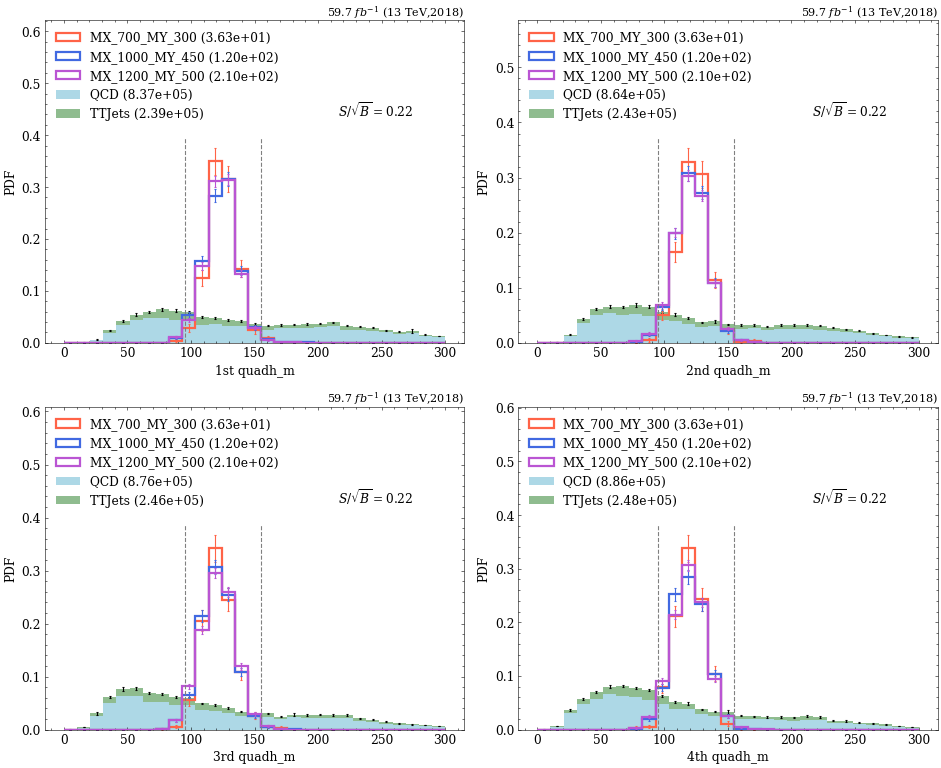

In [126]:
study.quick(
    signal+bkg,
    efficiency=True,
    legend=True,
    masks=[lambda t:t.nfound_paired_h==4]*len(signal),
    varlist=[f'quadh_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    exe=soverb(r=125, cut=30),
)

100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


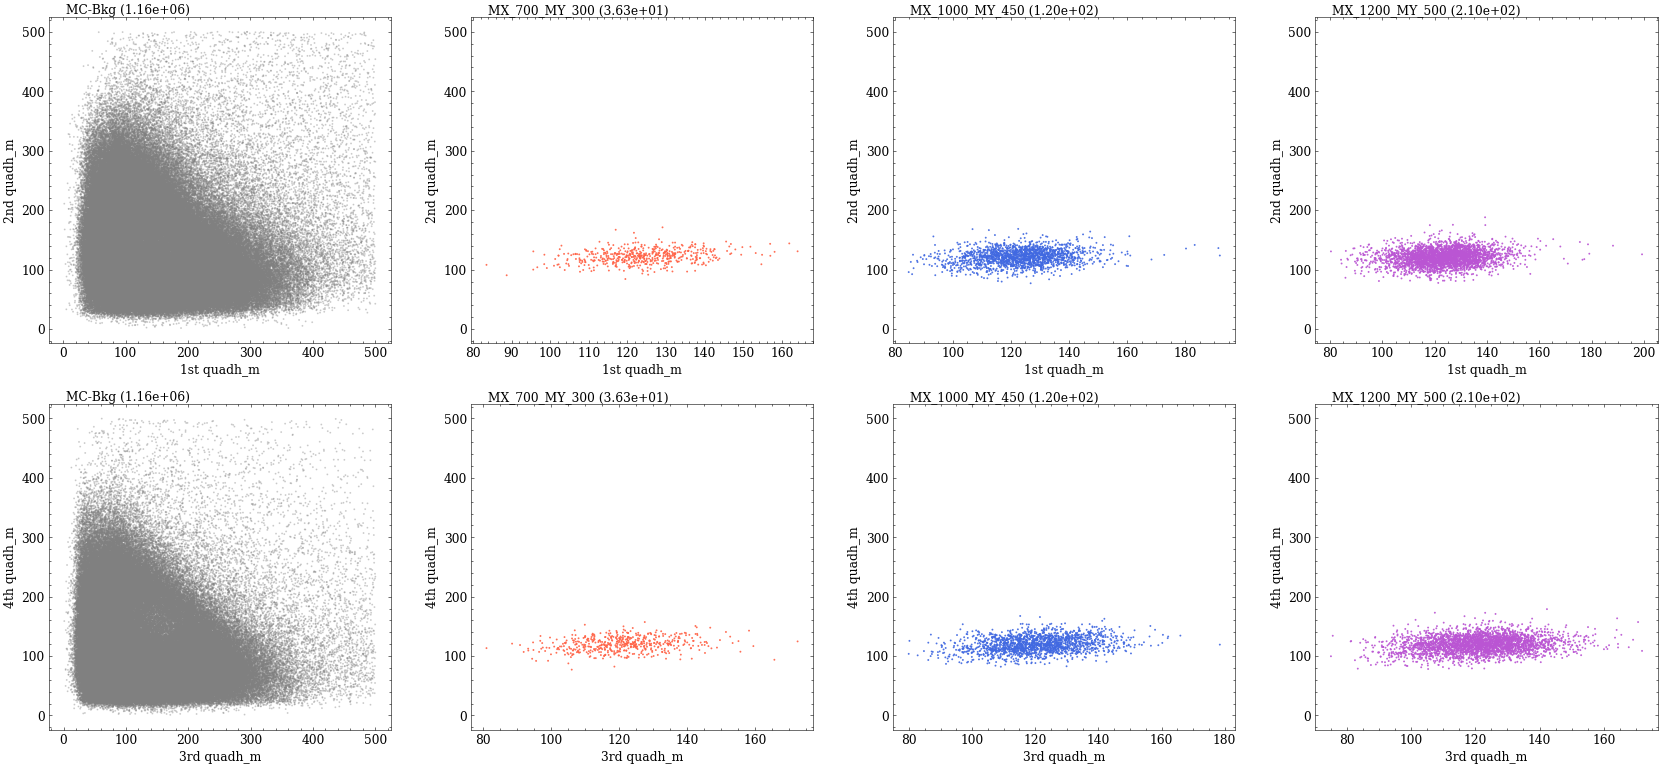

In [127]:
study.quick2d(
    signal+bkg,
    masks=[lambda t:t.nfound_paired_h==4]*len(signal),
    varlist=[f'quadh_m[:,{i}]' for i in range(4)],
    binlist=[(0,500,30)]*12,
    scatter=True,
)

100%|██████████| 4/4 [00:00<00:00,  9.69it/s]


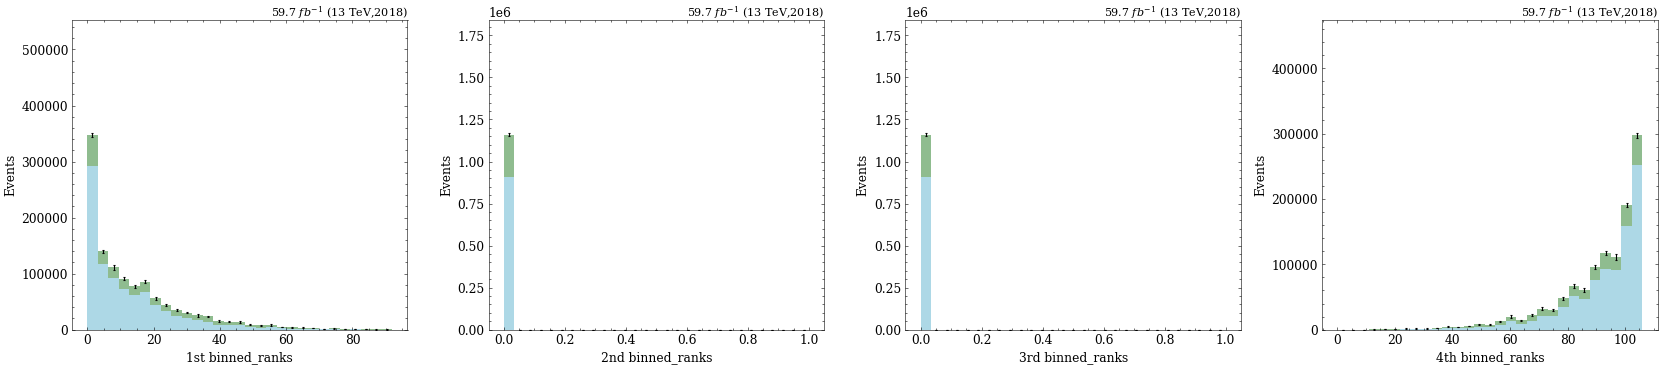

In [128]:
study.quick( 
    bkg,
    varlist=[f'binned_ranks[:,{i}]' for i in range(4)],
    h_rebin=30,
    dim=-1,
)

100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


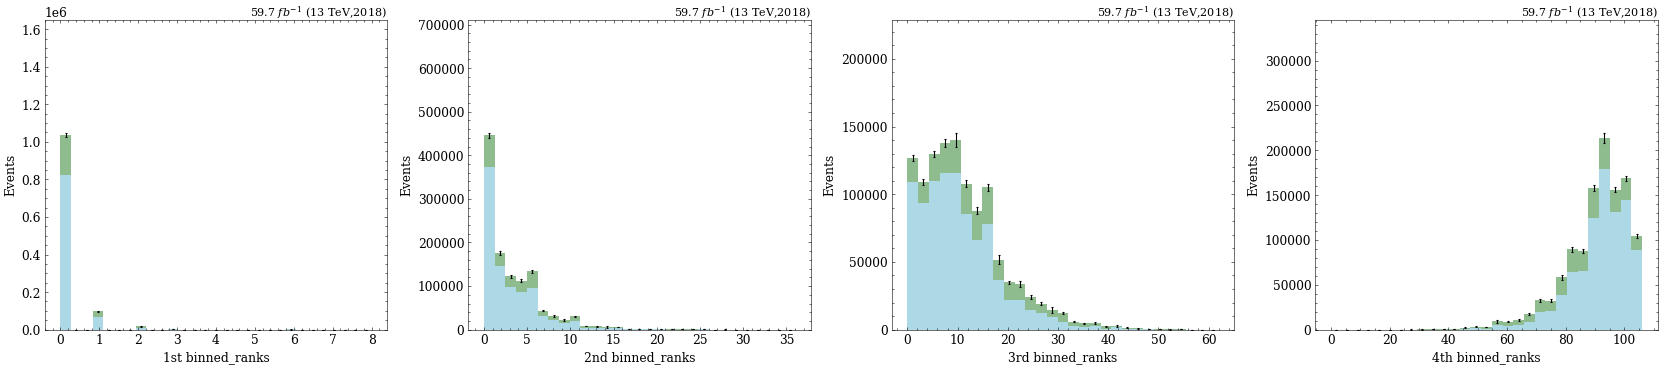

In [31]:
study.quick( 
    bkg,
    varlist=[f'binned_ranks[:,{i}]' for i in range(4)],
    h_rebin=30,
    dim=-1,
)

100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


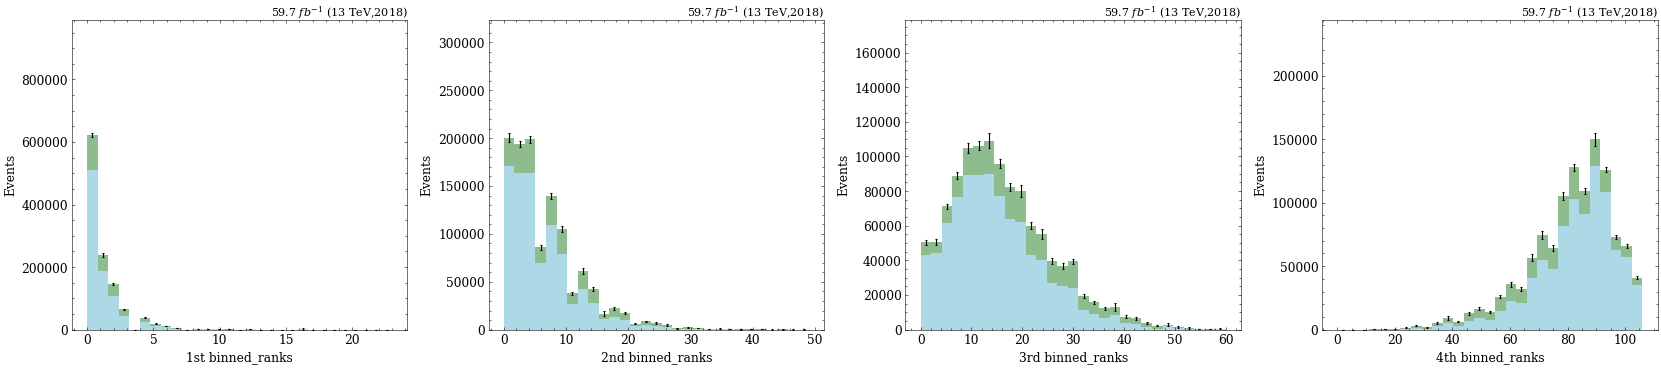

In [ ]:
study.quick( 
    bkg,
    varlist=[f'binned_ranks[:,{i}]' for i in range(4)],
    h_rebin=30,
    dim=-1,
)

100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


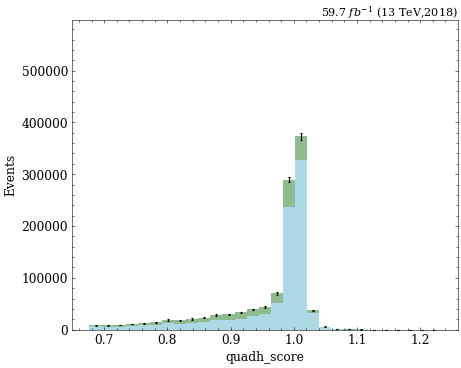

In [32]:
study.quick( 
    bkg,
    varlist=['quadh_score']
)

100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


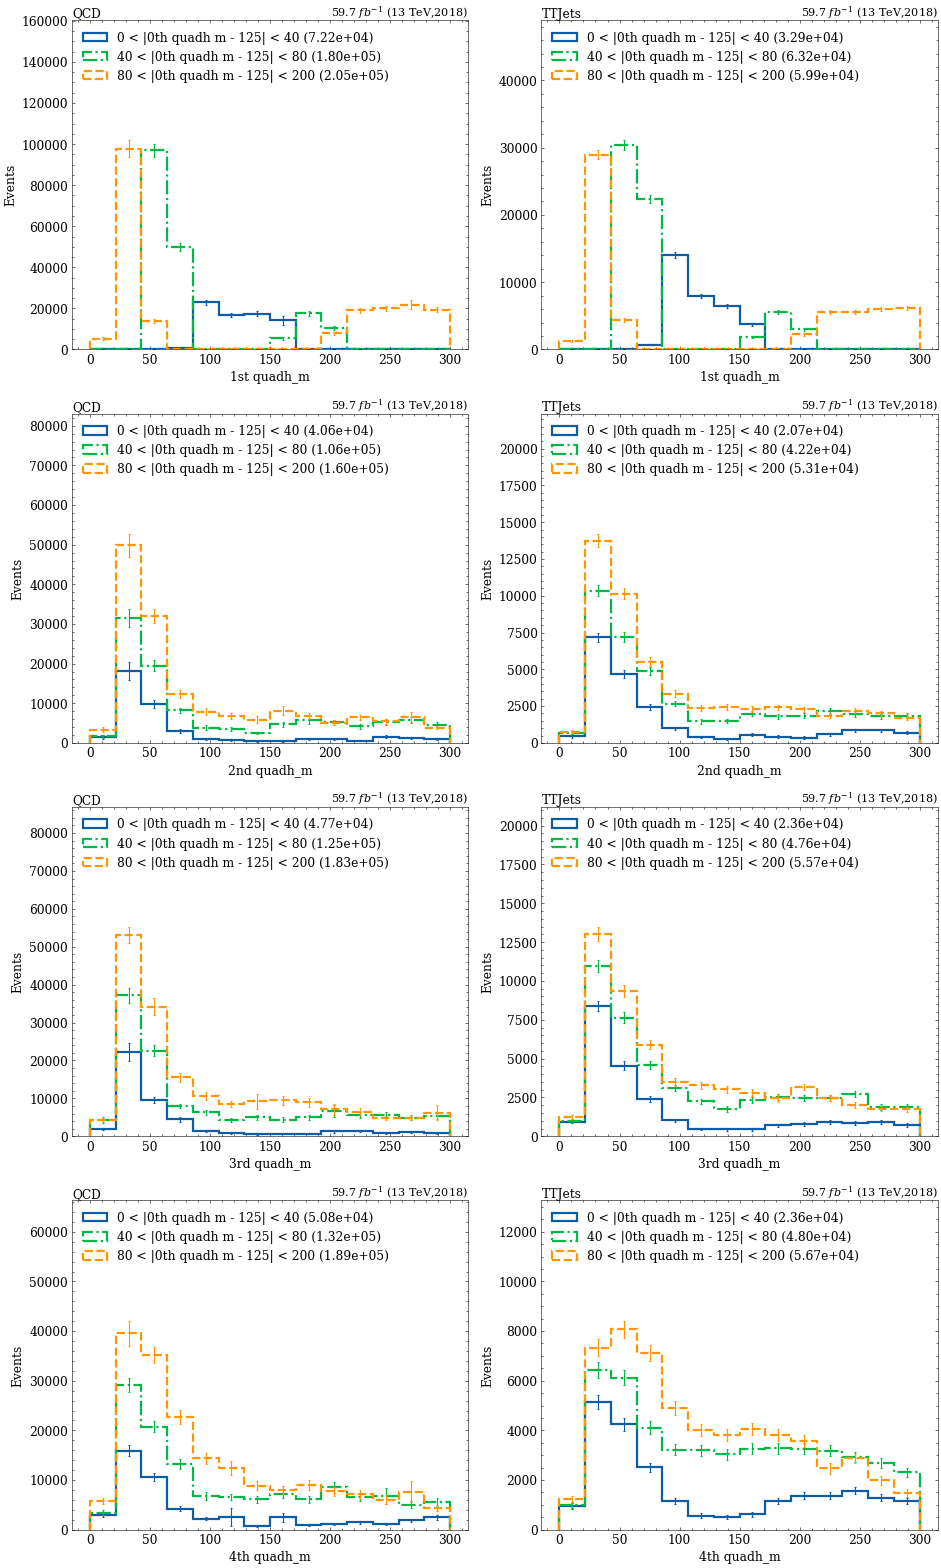

In [30]:
class quadh_dm_cut(ObjTransform):
    @property
    def __name__(self): return f'{self.lo} < |{ordinal(self.i)} quadh m - {self.r}| < {self.hi}'
    def __call__(self, t):
        dm = np.abs(t.quadh_m[:, self.i]-self.r)
        return (dm < self.hi) & (dm > self.lo)

study.compare_masks( 
    bkg, stacked=False,
    legend=True,
    masks=[quadh_dm_cut(i=0, r=125, lo=lo, hi=hi) for lo,hi in [(0,40),(40,80),(80,200)]],
    h_color=None,
    varlist=[f'quadh_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,15)]*4,
)

100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


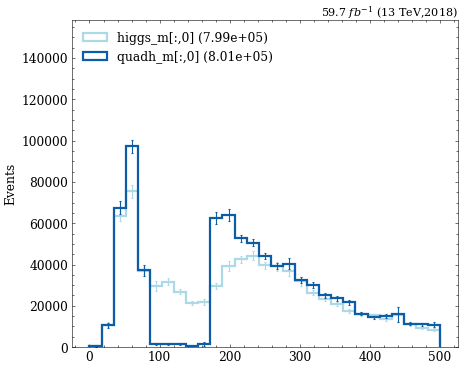

In [75]:
study.overlay(
    bkg[[0]], stacked=False,
    legend=True,
    label=['higgs_m[:,0]','quadh_m[:,0]'],
    varlist=['higgs_m[:,0]','quadh_m[:,0]'],
    binlist=[(0,500,30)]

)

<Array [190, 74.5, 38.7, 26.2] type='4 * float32'>

(432121, 4)

In [44]:
def count_h_dm(t, dm_cut=25):
    jet_p4 = build_p4(t, 'jet', use_regressed=True)
    j1, j2 = ak.unzip(ak.combinations(jet_p4, n=2, axis=-1))
    higgs_p4 = j1 + j2
    higgs_m = higgs_p4.m

    higgs_dm = np.abs(higgs_m - 125)
    dm_mask = higgs_dm < dm_cut

    n_quadh_dm = sum([ dm_mask[:,higgs_index] for higgs_index in quadh_index ])

    t.extend(
        **{
            f'n{i}_quadh_dm':ak.sum(n_quadh_dm==i,axis=-1)
            for i in (0,1,2,3,4)
        }
    )

In [45]:
(signal+bkg).apply(count_h_dm)

[None, None, None, None, None]

100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


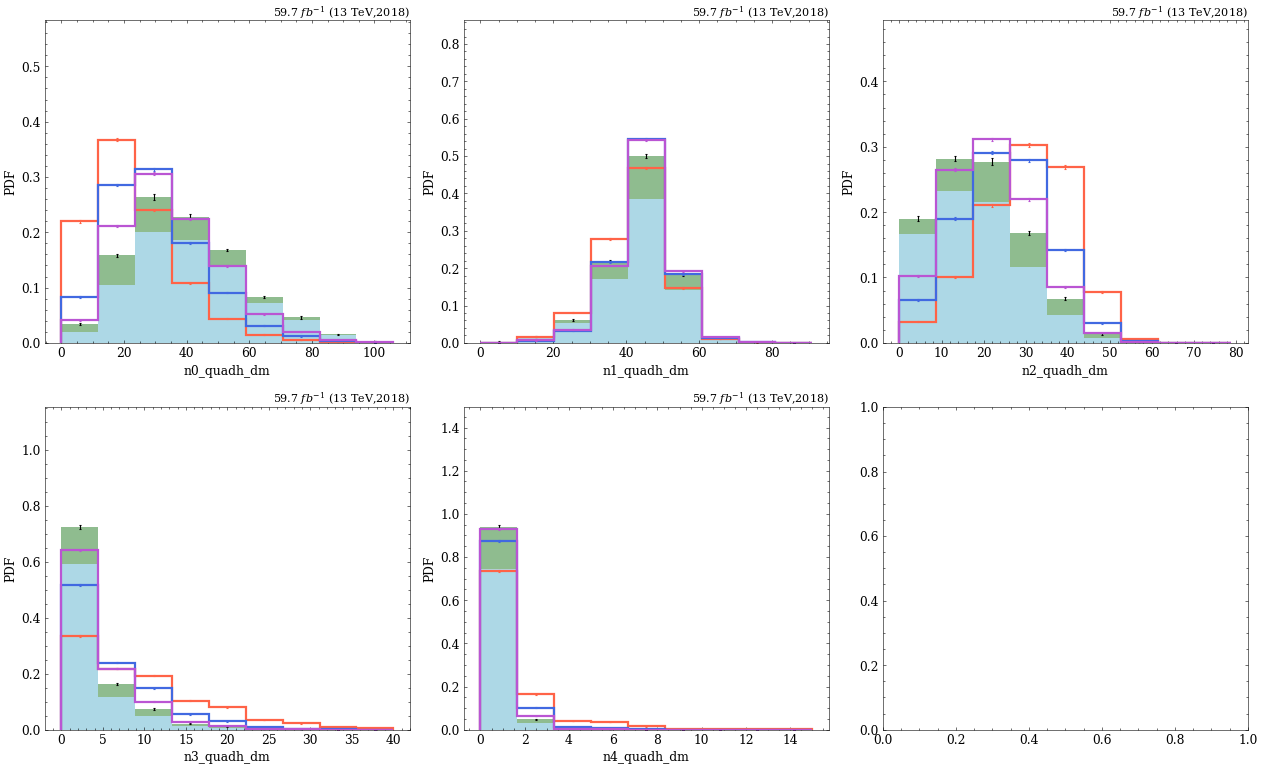

In [48]:
study.quick( 
    signal+bkg,
    varlist=[f'n{i}_quadh_dm' for i in range(5)],
    h_rebin=10,
    dim=-1,
    efficiency=True,
)

<Array [[0, 0, 0, 0, 0, 0, ... 0, 0, 1, 0, 0]] type='112149 * 105 * int64'>

In [7]:
def build_true_higgs(t):
    jp4 = build_p4(t, prefix='jet', use_regressed=True)
    order = ak.argsort(t.jet_signalId, axis=-1)
    j1_index = order[:, ::2]
    j2_index = order[:, 1::2]
    hp4 = jp4[j1_index] + jp4[j2_index]
    # j1_p4 = jp4[:, order[:, ]]
    return hp4.m


In [8]:
hm = signal.apply(build_true_higgs).cat

In [9]:
avg_hm = ak.mean(hm, axis=-1)

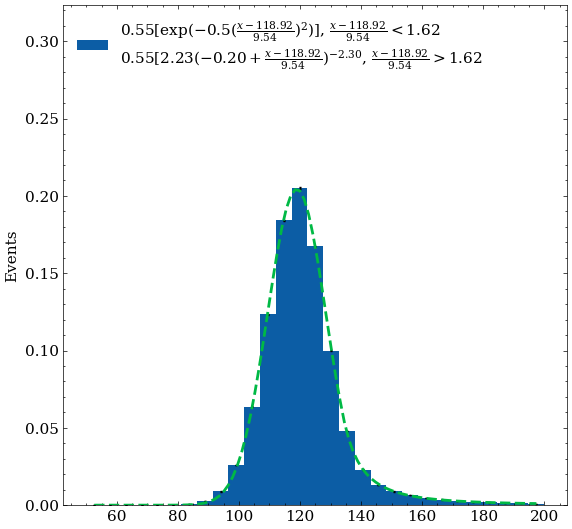

In [101]:
_, _, histo = histo_array( avg_hm, bins=(50,200,30), h_efficiency=True, 
h_fit='crystalball', h_fit_show=True,h_label_stat="{fit:0.2f}", 
legend=True 
)

In [105]:
graph = Graph.from_histo(histo)

normalize = lambda x : (x.max() - x)/(x.max() - x.min())


graph.y_array = normalize(graph.y_array)

In [106]:
discrete = lambda x : 1.0*( np.abs(x - 125) > 50 )
discrete = Graph(graph.x_array, discrete(graph.x_array))

In [108]:
fit = histo.fit
fit.y_array = normalize(fit.y_array)

In [110]:
graph.fit = fit

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:>)

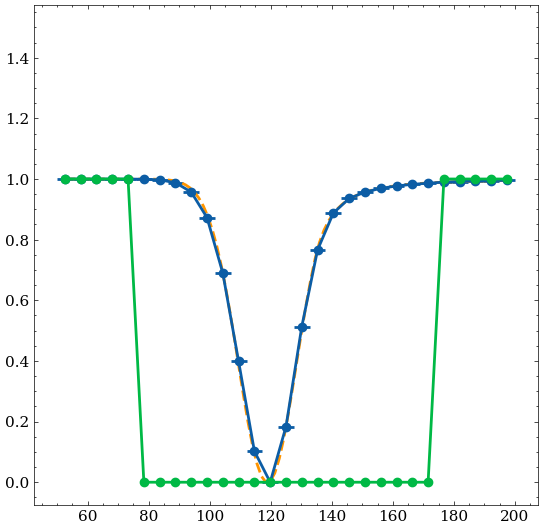

In [111]:
plot_graphs([graph, discrete])